In [1]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
# @title import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     |████████████████████████████████| 9.6 MB 7.7 MB/s 
     |████████████████████████████████| 13.3 MB 76 kB/s 
     |████████████████████████████████| 77 kB 2.8 MB/s 
     |████████████████████████████████| 3.2 MB 34.1 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 179 kB 34.8 MB/s 


In [3]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [4]:
# @title select channels
electrode_indexes = []
electrode_indexes.append([])
electrode_indexes.append([])

for subject_index, subject in enumerate(alldat):
  electrode_indexes[0].append([])
  electrode_indexes[1].append([])
  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes[0][subject_index].append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes[1][subject_index].append(gyrus_index)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

<Figure size 648x648 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


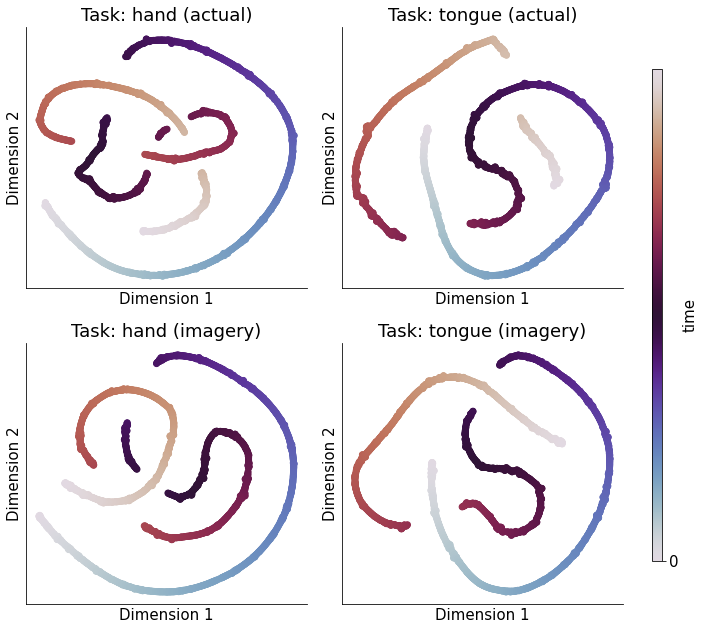

In [51]:
from scipy.stats import zscore
import matplotlib as mpl

import torch
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_subdata_allroi(sub_ID, condi_ID, stim_ID, band_limit):
  from scipy import signal

  dat = alldat[sub_ID][condi_ID] 

  ele_used = np.concatenate((electrode_indexes[0][sub_ID],electrode_indexes[1][sub_ID]), axis=0)
  # print(ele_used)

  # filter the data
  # V is the voltage data
  V = dat['V'].astype('float32')
  V = V[:, ele_used]

  # low-pass filter below 200 Hz
  b, a = signal.butter(3, band_limit[1], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # high-pass filter above 1 Hz
  b, a = signal.butter(3, band_limit[0], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # calculate the power
  # V_tmp = signal.hilbert(V) 8-12
  # V = np.abs(V_tmp) ** 2

  # average the broadband power across all tongue and hand trials
  nt, nchan = V.shape
  nstim = len(dat['t_on'])

  trange = np.arange(0, 2000)
  ts = dat['t_on'][:, np.newaxis]

  ts = ts + trange

  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

  task = 12
  if stim_ID == 0:
    task = 11

  V_epochs = (V_epochs[dat['stim_id'] == task]).mean(0)

  return V_epochs


def plot_trajectory(data, ax):
    # plot
    # fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

    data_tensor = torch.from_numpy(data)

    # First do PCA to reduce dimensionality to 20 dimensions so that tSNE is faster
    resp_lowd = PCA(n_components=min(20, data_tensor.shape[1]), random_state=0).fit_transform(data_tensor)

    # Then do tSNE to reduce dimensionality to 2 dimensions
    resp_lowd = TSNE(n_components=2, random_state=0).fit_transform(data_tensor)
    # print(resp_lowd.shape)
    # Plot dimensionality-reduced population responses 'resp_lowd'
    # on 2D axes, with each point colored by stimulus orientation
    time = np.arange(0, 2000)
    time = torch.from_numpy(time)
    # print(time.shape)

    x, y = resp_lowd[:, 0], resp_lowd[:, 1]
    # print(resp_lowd[:, 0])

    pts = ax.scatter(x, y, c=time, cmap='twilight', vmin=0, vmax=2000)
    # plt.colorbar(pts, ticks=np.linspace(0, 2000, 1), label='time')

    ax.set_title("Task: %s (%s)" % (task_name[istim], condi_name[icondi]))
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_xticks([])
    ax.set_yticks([])

    return pts

# basic setting
band_limit = [1, 200]
condi_name = ['actual', 'imagery']
task_name = ['hand', 'tongue']
plt.figure(figsize=(9, 9))
fig, axes = plt.subplots(2, 2, figsize=(9,9))

for icondi in range(2):
  for istim in range(2):
    data = np.empty((2000,0),int)

    # get data of all subj
    for isub in range(7):
      data_sub = get_subdata_allroi(isub, icondi, istim, band_limit)
      #print(data_sub.shape)
      data = np.hstack((data, data_sub))
      #print(data.shape)
    
    # ax = plt.subplot(2, 2, icondi * 2 + istim + 1)
    ax = axes[icondi][istim]
    pts = plot_trajectory(data, ax)

# fig.subplots_adjust(right = 0.9)

# colorbar
l=1.02
b=0.12
w=0.015
h=1-2*b

rect = [l,b,w,h]
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(pts, cax = cbar_ax, ticks=np.linspace(0, 2000, 1), label='time')
plt.show()

